## Haystack Example & Observability with [`langsmith`](https://docs.arize.com/phoenix)
---

Haystack is an AI orchestration framework to build customizable, production-ready LLM applications. Connect components (models, vector DBs, file converters) to pipelines or agents that can interact with your data. With advanced retrieval methods, it's best suited for building RAG, question answering, semantic search or conversational agent chatbots.

Haystack provides [pipelines](https://docs.haystack.deepset.ai/docs/pipelines) and Agents, two powerful structures for designing LLM applications for various use cases including search, question answering, and conversational AI. With a big focus on state-of-the art retrieval methods and solid evaluation metrics, it provides you with everything you need to ship a reliable, trustworthy application. You can serialize pipelines to YAML files, expose them via a REST API, and scale them flexibly with your workloads, making it easy to move your application from a prototype stage to production.

This notebook also shows functionality to get insights into different metrics using the open-source observability tool, `Langsmith`. LangSmith has LLM-native observability, allowing you to get meaningful insights into your application. Note that observability is important throughout all stages of application development - from prototyping, to beta testing, to production. There are different considerations at all stages, but they are all intricately tied together. In this tutorial we walk through the natural progression.

### Haystack Basics:
---

Haystack is built on the concept of two main architectures: Components + Pipelines. We create pipelines by combining the components needed for our application.

![Pipeline structure](/images/pipeline_structure.png)

Pipelines are structures created by components - this can be a RAG application, A simple application to store embeddings to a vector store, etc. We attach the components structure together to create a pipeline.

**_A pipeline can do two things: Branching + Looping._**

#### What are components?

Components are a certain entity that expects an input and produces a certain number of outputs (this is at the flexibility of the user). Haystack provides some components options: Generators, embedders, doc pre-processors. You can build your own component as well.

You can also start attaching components to each other as given below if the output and input type match. The first component takes a string and produces an embedding (which is an Embedder) and the next component is a retriever which takes in embeddings and generates a document from it.

![Component structure](/images/components.png)


### Classic RAG pipeline

![RAG pipeline structure](https://raw.githubusercontent.com/madhurprash/GenAI_AppDev_Frameworks/main/images/rag_pipeline.png)

Here, we have 4 components: an embedder, a retriever to return documents, a prompt builder, and a generator. There are several component types that are supported. 

#### You can build your own component

``` {.python}
from typing import List
from haystack import component

@component
class Translator:
    
    # define the output type of the component
    # this is used for pipeline validation down the line
    @component.output_types(documents=List[Document])
    def run(self, 
            from_lang: str = 'en', 
            to_lang: str = 'fr', 
            documents:List[Document]):
        translated_documents = []
        # translate documents from_lang to to_lang and add
        # them to the translated_documents
        return {"documents": translated_documents}
```

For more information on Haystack, view the documentation on Haystack pipelines and components [here](https://docs.haystack.deepset.ai/docs/pipelines#yaml-file-definitions).

### Creating Pipelines: Simple RAG application
--- 

In this portion of the notebook, we will create a simple RAG application pipeline using Haystack components.

### Prerequisite

Make sure to run this notebook using the `oss_genai_appdev` conda environment. This environment has all necessary libraries installed, such as `haystack`, `sentence-transformers`, `langmsith` and so on. Run the following command to create the environment and install the necessary packages before running this notebook:

```.bash
pip install -r requirements.txt
```

In [1]:
!pip install -r ../requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
# import dependencies
import os
import boto3
import logging
from haystack import Pipeline
from openinference.instrumentation.bedrock import BedrockInstrumentor

# Set a logger
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

# initialize a haystack pipeline
pipeline = Pipeline()

# define some global variables
AWS_REGION: str = "us-east-1"
BEDROCK_HAIKU_MODELID: str = "anthropic.claude-3-haiku-20240307-v1:0"
SONNET_3_5_MODELID: str = "anthropic.claude-3-5-sonnet-20240620-v1:0"
SONNET_MODELID: str = "anthropic.claude-3-sonnet-20240229-v1:0"
TITAN_TEXT_EMBED_MODELID: str = "amazon.titan-embed-text-v2:0"

# initialize the required langsmith variables
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"]="YOUR-LANGCHAIN-API-KEY"
os.environ["LANGCHAIN_ENDPOINT"]="YOUR-LANGCHAIN-ENDPOINT"
os.environ["LANGCHAIN_PROJECT"]="bedrock-rag-app"

In [3]:
# import the in memory document store 
from haystack.document_stores.in_memory import InMemoryDocumentStore

# initialize the document store
document_store = InMemoryDocumentStore()

In [4]:
# initialize the embedders and writers as a part of the RAG pipeline
from haystack.components.writers import DocumentWriter
from haystack_integrations.components.embedders.amazon_bedrock import (
    AmazonBedrockDocumentEmbedder,
    AmazonBedrockTextEmbedder
)

# Initialize the Bedrock document embedder with Titan model
document_embedder = AmazonBedrockDocumentEmbedder(
    model=TITAN_TEXT_EMBED_MODELID,
    aws_region=AWS_REGION
)

# Now, let's add the embedder and writer components to the RAG pipeline.
# The sentence transformer document embedder uses the 'all-mpnet-base-v2' model as default
pipeline.add_component('embedder', document_embedder)
# whenever we use a document writer it writes document to the document store
pipeline.add_component('writer', DocumentWriter(document_store))

# once we have added the embedder and writer components, we can connect them to the RAG pipeline.
pipeline.connect('embedder', 'writer')

[2024-12-13 16:37:03,031] p38795 {credentials.py:1278} INFO - Found credentials in shared credentials file: ~/.aws/credentials


🚅 Components
  - embedder: AmazonBedrockDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - embedder.documents -> writer.documents (List[Document])

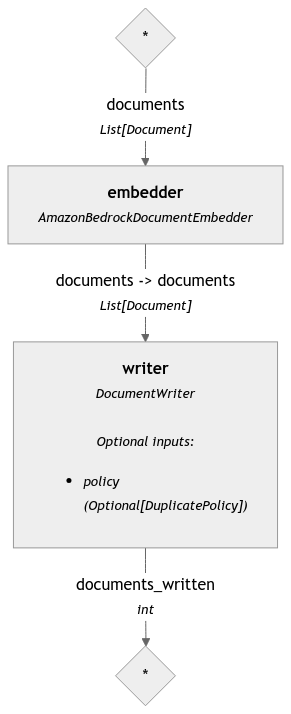

In [5]:
# Now we can do Pipeline.show() to view all of the components that are a part of our RAG
# application
pipeline.show()

Now, we can see that there are no documents in the `pipeline.show()` above. This is useful when building complex pipelines doing branching and looping. 

Embedder expects documents so let's add some documents:

### Initialize `Langsmith` tracing using the `@traceable` decorator. Tracing is a powerful tool for understanding the behavior of your LLM application. 
---

We will be using `langsmith` below to trace logs to our `bedrock-rag-app` project when we start running the bedrock embeddings model via haystack

In [6]:
from langsmith import traceable
from haystack.dataclasses import Document

# Create synthetic data
synthetic_data = [
    "Amazon Web Services (AWS) is a comprehensive cloud computing platform.",
    "AWS offers a wide range of services including compute, storage, and machine learning.",
    "Elastic Compute Cloud (EC2) is a web service that provides resizable compute capacity in the cloud.",
    "Amazon S3 is an object storage service offering industry-leading scalability and data availability.",
    "AWS Lambda lets you run code without provisioning or managing servers."
]

@traceable
def embed_docs(data):
    """
    Here, we will embed the documents using the Titan model. This is a simple example
    """
    return [Document(content=item) for item in data]

@traceable
def run_embedding_pipeline(documents):
    """
    Here, we will run the embedding pipeline.
    """
    return pipeline.run({
        "embedder": {
            "documents": documents
        }
    })

documents = embed_docs(synthetic_data)
run_embedding_pipeline(documents)

[2024-12-13 16:37:05,914] p38795 {pipeline.py:75} INFO - Running component embedder
Creating embeddings: 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]
[2024-12-13 16:37:07,348] p38795 {pipeline.py:75} INFO - Running component writer


{'writer': {'documents_written': 5}}

### View traces on the `langsmith` dashboard
---

Below, we will see the two traces, one for embedding the documents and another trace for running the pipeline:

![dashboard](/images/langsmith-dashboard.png)

![data-1](/images/langsmith_data1.png)

![data-2](/images/langsmith-data2.png)

In [7]:
# Once the docs are written to the document store, we can filter to view the documents that are loaded, 
# along with vector representations of the documents
document_store.filter_documents()

[Document(id=46761d097feb256e97645a64f3c90a2996aae348dcd479ada5ece60dce965b74, content: 'Amazon Web Services (AWS) is a comprehensive cloud computing platform.', embedding: vector of size 1024),
 Document(id=db8dcb9c4353f4d5e6f969f0a56a9d4d6365afc417dbb2bd6699aaa9bdc703ee, content: 'AWS offers a wide range of services including compute, storage, and machine learning.', embedding: vector of size 1024),
 Document(id=517f1685dd26674db61cbdeaf01b3c385f0862c33eeaa86a3eb9bec678b56349, content: 'Elastic Compute Cloud (EC2) is a web service that provides resizable compute capacity in the cloud.', embedding: vector of size 1024),
 Document(id=261646794e149651c2b53065db77a6c5611612de4ce12374e4bb78383a061c81, content: 'Amazon S3 is an object storage service offering industry-leading scalability and data availability.', embedding: vector of size 1024),
 Document(id=2c36da493e0d66835d486146d64e238c417a7f510599469e0977534ded3ee543, content: 'AWS Lambda lets you run code without provisioning or manag

### Build a RAG Pipeline using Amazon Bedrock
---

In this portion of the notebook, we build a RAG pipeline with other components. These include the prompt builder, the SentenceTransformersTextEmbedder, the InMemoryEmbeddingRetriever since we have already ingested documents in the document store and a `BedrockGenerator` to generate responses. There are several components that are provided as options, you can build your own component too.

In [8]:
# Import necessary modules
from haystack.components.builders import PromptBuilder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack_integrations.components.generators.amazon_bedrock import AmazonBedrockGenerator

# initialize the retriever
retriever = InMemoryEmbeddingRetriever(document_store=document_store)

# Initialize the Bedrock document embedder with Titan model
rag_document_embedder = AmazonBedrockTextEmbedder(
    model=TITAN_TEXT_EMBED_MODELID,
    aws_region=AWS_REGION
)

# Build the prompt template. In haystack prompt template is all done with jinja templating
prompt_template = """Given the following context, answer the question. Follow the instructions below
while answering the question given in the <instructions></instructions> xml tags:

<instructions>
- Answer the question in a clear and concise manner.
- If the answer is not in the context, say "I don't know"
</instructions>

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{ question }}
"""

/opt/homebrew/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/homebrew/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: h

In [9]:
prompt_builder = PromptBuilder(template=prompt_template)
# initialize the generator
generator = AmazonBedrockGenerator(model=BEDROCK_HAIKU_MODELID)

[2024-12-13 16:40:24,175] p38795 {credentials.py:1278} INFO - Found credentials in shared credentials file: ~/.aws/credentials


#### Construct the RAG pipeline
---

Now that we have defined the prompt template, the generator, let's construct the RAG pipeline by adding these components and connecting each component based on relevant inputs and outputs.

In [10]:
rag_document_embedder

Inputs:
  - text: str
Outputs:
  - embedding: List[float]

In [11]:
bedrock_rag_pipeline = Pipeline()

bedrock_rag_pipeline.add_component('embedder', rag_document_embedder)
bedrock_rag_pipeline.add_component('retriever', retriever)
bedrock_rag_pipeline.add_component('prompt_builder', prompt_builder)
bedrock_rag_pipeline.add_component('generator', generator)

# The retriever is connected directly to the prompt_builder
bedrock_rag_pipeline.connect('embedder.embedding', 'retriever.query_embedding')
bedrock_rag_pipeline.connect('retriever', 'prompt_builder.documents')
bedrock_rag_pipeline.connect('prompt_builder', 'generator')

🚅 Components
  - embedder: AmazonBedrockTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - generator: AmazonBedrockGenerator
🛤️ Connections
  - embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)

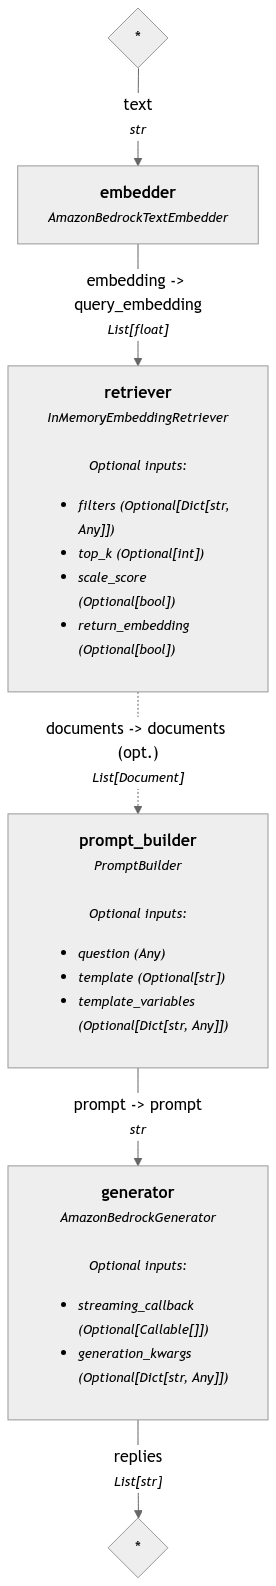

In [12]:
bedrock_rag_pipeline.show()

In [13]:
@traceable
def haystack_rag_query(question):
    """
    Run the pipeline to ask a question.
    """
    response = bedrock_rag_pipeline.run(
        {
            "embedder": {
                "text": question
            },
            "prompt_builder": {
                "question": question
            }
        }
    )
    return response
question = "What is Amazon Elastic Compute Cloud (EC2)?"
response = haystack_rag_query(question)
if "generator" in response and "replies" in response["generator"]:
    print("\nQuestion:", question)
    print("\nAnswer:", response["generator"]["replies"][0])

[2024-12-13 16:42:14,796] p38795 {pipeline.py:75} INFO - Running component embedder
[2024-12-13 16:42:15,315] p38795 {pipeline.py:75} INFO - Running component retriever
[2024-12-13 16:42:15,321] p38795 {pipeline.py:75} INFO - Running component prompt_builder
[2024-12-13 16:42:15,322] p38795 {pipeline.py:75} INFO - Running component generator



Question: What is Amazon Elastic Compute Cloud (EC2)?

Answer: <instructions>
- Answer the question in a clear and concise manner.
- If the answer is not in the context, say "I don't know"
</instructions>

Amazon Elastic Compute Cloud (EC2) is a web service that provides resizable compute capacity in the cloud, as mentioned in the context provided.


In [14]:
response['generator']['replies'][0]

'<instructions>\n- Answer the question in a clear and concise manner.\n- If the answer is not in the context, say "I don\'t know"\n</instructions>\n\nAmazon Elastic Compute Cloud (EC2) is a web service that provides resizable compute capacity in the cloud, as mentioned in the context provided.'

### `Langsmith` metrics
---

View some of the metrics that get logged into the langsmith dashboard. Now we can see another trace added for inferences. So in total we have 3 trace components: 1/ Embedding documents, 2/ Running the embedding pipeline and 3/ Running the retrieval pipeline.

![inference](/images/langsmith_full.png)

![inference-data](/images/langsmith-inference-call.png)